This jupyter notebook emulates multi_model_comp

In [1]:
import numpy as np
import pandas as pd
import pylab
from src.batch_fitting_module import master
import matplotlib.backends.backend_pdf

import src.Trait_SIn as mod

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano


In [26]:
def mod_plot(df,hpred,vpred,predtime):
    f,ax = pylab.subplots(1,2,figsize=[9,4.5])
    ax[0].errorbar(df.loc['host']['time'],df.loc['host']['abundance'],yerr=df.loc['host']['uncertainty'])
    ax[1].errorbar(df.loc['virus']['time'],df.loc['virus']['abundance'],yerr=df.loc['virus']['uncertainty'])
    ax[0].set_xlabel('Time (days)')
    ax[1].set_xlabel('Time (days)')
    ax[0].set_ylabel('Hosts ml$^{-1}$')
    ax[1].set_ylabel('Viruses ml$^{-1}$')
    ax[0].plot(predtime,hpred,label="fitted")
    ax[1].plot(predtime,vpred)
    ax[0].semilogy()
    ax[1].semilogy()
    return ax



In [27]:
df=pd.read_csv('data/testdat.csv')
df = df.set_index('organism')
prep = mod.SIn(df,Infection_states=0)
prep

Number of Infection States = 0
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 50

array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
       <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
      dtype=object)

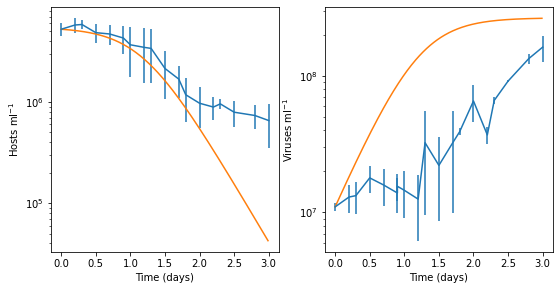

In [29]:
h,v=prep.integrate()
mod_plot(df,h,v,prep.times)

In [34]:
pall,likelihoods,iterations,posterior = prep.fit(nits=10000,pits=1000,burnin=5000)

a priori error 124.59759438907214
iteration; error; acceptance ratio
1000 ; 14.08 ; 0.0
2000 ; 12.61 ; 0.0
3000 ; 12.78 ; 0.0
4000 ; 13.44 ; 0.0
5000 ; 12.91 ; 0.0
6000 ; 12.56 ; 0.675
7000 ; 13.69 ; 0.671
8000 ; 12.52 ; 0.661
9000 ; 14.64 ; 0.656


In [35]:
postmelt = posterior.melt()

,variable,value
0,mu,4.472227e-08
1,mu,4.605352e-08
2,mu,4.628635e-08
3,mu,4.956677e-08
4,mu,5.583449e-08
...,...,...
20029,Iteration,9.993000e+03
20030,Iteration,9.994000e+03
20031,Iteration,9.995000e+03
20032,Iteration,9.997000e+03


In [17]:
%%R -i postmelt
library('ggplot2')




array([5236900.        , 5230832.57843104, 5224608.29434647,
       5218223.50142826, 5211674.4878469 , 5204957.47867674,
       5198068.63629206, 5191004.06223316, 5183759.79621521,
       5176331.81736214, 5168716.04435294, 5160908.33578997,
       5152904.49287457, 5144700.25919038, 5136291.32180815,
       5127673.31353201, 5118841.8129653 , 5109792.34713858,
       5100520.39389176, 5091021.38173174, 5081290.69436875,
       5071323.67190714, 5061115.61232265, 5050661.77683175,
       5039957.39037469, 5028997.64508498, 5017777.70603825,
       5006292.71116689, 4994537.77585609, 4982507.99934766,
       4970198.46795434, 4957604.25950761, 4944720.44778171,
       4931542.10585023, 4918064.31413224, 4904282.16507554,
       4890190.76842505, 4875785.2576372 , 4861060.79624206,
       4846012.58457047, 4830635.86689545, 4814925.93818782,
       4798878.15173441, 4782487.92706553, 4765750.75783965,
       4748662.22014206, 4731217.98106293, 4713413.80752969,
       4695245.57545638,

# pymc3

In [6]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import arviz as az
import theano

In [7]:
y = odeint(prep.get_model(), t=prep.times, y0=prep.get_inits(), args=prep.get_parameters())
yobs = np.random.normal(y,2)

In [8]:
prep.get_inits()

array([ 5236900., 10981000.])

In [9]:
times = prep.times
mod = prep.get_model()
ode_model = DifferentialEquation(
    func=mod,
    times=times,
    n_states=2,
    n_theta=3,
)

In [32]:
init = list(prep.get_inits())

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    #sigma = pm.HalfCauchy('sigma', 1)
    #gamma = pm.Lognormal('gamma',0, 1)
    #mu = pm.Lognormal('mu',1e-06, 1)
    mu = pm.Normal('mu',1e-06, 1e-06,transform=pm.distributions.transforms.log)
    phi = pm.Normal('phi',1e-08, 1e-08,transform=pm.distributions.transforms.log)
    beta = pm.Normal('beta',50, 10)
    #beta = pm.Deterministic("x plus 2", beta + 2)
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=init, theta=[mu,phi,beta])
    # The ode_solution has a shape of (n_times, n_states)
    
    #Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(100, tune=1000, cores=7)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [beta, phi, mu]


Sampling 7 chains for 1_000 tune and 100 draw iterations (7_000 + 700 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6618558548520787, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


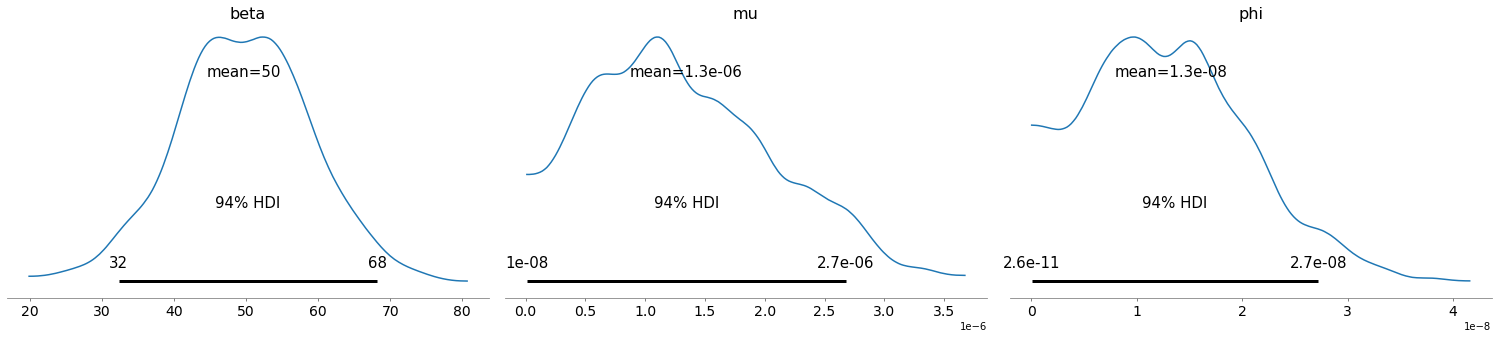

In [33]:
az.plot_posterior(data);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [beta, phi, mu]


Sampling 7 chains for 1_000 tune and 10_000 draw iterations (7_000 + 70_000 draws total) took 11 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8809766878295427, but should be close to 0.8. Try to increase the number of tuning steps.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


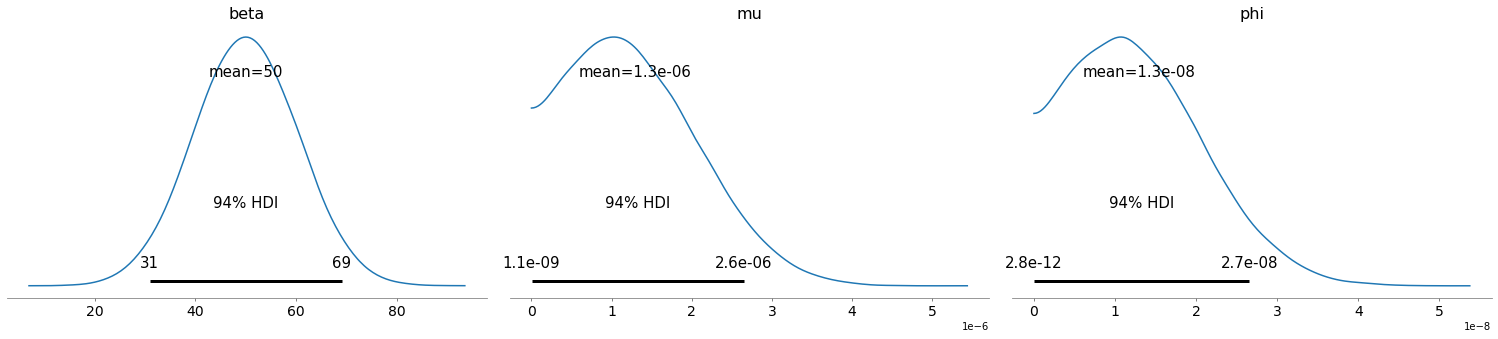

In [34]:
init = list(prep.get_inits())

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    #sigma = pm.HalfCauchy('sigma', 1)
    #gamma = pm.Lognormal('gamma',0, 1)
    #mu = pm.Lognormal('mu',1e-06, 1)
    mu = pm.Normal('mu',1e-06, 1e-06,transform=pm.distributions.transforms.log)
    phi = pm.Normal('phi',1e-08, 1e-08,transform=pm.distributions.transforms.log)
    beta = pm.Normal('beta',50, 10)
    #beta = pm.Deterministic("x plus 2", beta + 2)
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=init, theta=[mu,phi,beta])
    # The ode_solution has a shape of (n_times, n_states)
    
    #Y = pm.Normal('Y', mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(10000, tune=1000, cores=7)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
az.plot_posterior(data);

In [38]:
posterior_predictive

{}